# Simulation of an analog signal from a senor and subsequent analysis

michael@databooth.com.au

## Initial setup

Load the required packages (libraries)

In [1]:
# DONE: !pip install RPi.GPIO - only works on Raspberry Pi

In [2]:
import time
import random
from datetime import datetime, timedelta
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import uuid

In [3]:
try:
    import RPi.GPIO as GPIO

    GPIO.setmode(GPIO.BCM)
    GPIO.setup(18, GPIO.IN)
except Exception as e:
    print(f"Import error: RPi.GPIO - {e}")

Import error: RPi.GPIO - No module named 'RPi'


In [4]:
N_OBSERVATION = 50
MAX_TIME_EXPERIMENT_SECONDS = 2 * 60
MAX_SENSOR_VALUE = 100.0
MAX_TIME_DIFF_SECONDS = 10
DATA_FILE = Path.cwd().parent / "data" / "sensor_data.csv"

Define any custom (user-defined) functions

In [5]:
def generate_uuid_from_datetime(current_time):
    timestamp = current_time.timestamp()
    unique_id = uuid.uuid5(uuid.NAMESPACE_DNS, str(timestamp))
    return unique_id

In [6]:
def read_analog_sensor(max_sensor_value=MAX_SENSOR_VALUE):
    sensor_value = random.uniform(
        0.0, max_sensor_value
    )  # this is returning a number in this (arbitrary range) - to simulate a reading from the sensor
    return sensor_value

In [7]:
def acquire_data(dt, data, sensor_data):
    sensor_data.append((dt, data))  # storing the data (for later use)
    return None

## Data Collection

Simulate the collection (capture) of data from the sensor for up to `N_OBSERVATION` observations (including random times between observations) or until the `MAX_TIME_EXPERIMENT_SECONDS` is reached.

In [8]:
def collect_data(n_observation=None, max_time=None):
    sensor_data = []
    acquisition_datetime = datetime.now()
    file_uuid = generate_uuid_from_datetime(acquisition_datetime)
    if n_observation is None:
        n_observation = N_OBSERVATION
    if max_time is None:
        max_time = MAX_TIME_EXPERIMENT_SECONDS
    print(
        f"Starting data collection at {acquisition_datetime} for maximum of {n_observation} observations or {max_time} seconds\n"
    )
    stop_datetime = acquisition_datetime + timedelta(seconds=max_time)
    counter = 0
    while counter < N_OBSERVATION and acquisition_datetime < stop_datetime:
        counter += 1
        sensor_value = read_analog_sensor()
        time_ran = random.uniform(0, MAX_TIME_DIFF_SECONDS)  # time between 0 and 5 seconds
        acquisition_datetime += timedelta(seconds=time_ran)
        print(f"{counter: 3d}: {acquisition_datetime}; Time since last: {time_ran:.3f} s; Sensor value: {sensor_value:.7f}")
        acquire_data(acquisition_datetime, sensor_value, sensor_data)
        time.sleep(time_ran)
    return sensor_data, file_uuid

In [9]:
sensor_data, file_uuid = collect_data()

Starting data collection at 2023-06-17 17:23:59.526513 for maximum of 50 observations or 120 seconds

  1: 2023-06-17 17:24:04.528671; Time since last: 5.002 s; Sensor value: 86.5118337
  2: 2023-06-17 17:24:04.640893; Time since last: 0.112 s; Sensor value: 19.8745697
  3: 2023-06-17 17:24:09.880334; Time since last: 5.239 s; Sensor value: 30.2197561
  4: 2023-06-17 17:24:12.681557; Time since last: 2.801 s; Sensor value: 63.0271255
  5: 2023-06-17 17:24:22.427097; Time since last: 9.746 s; Sensor value: 35.4083322
  6: 2023-06-17 17:24:28.158105; Time since last: 5.731 s; Sensor value: 11.7581502
  7: 2023-06-17 17:24:28.410143; Time since last: 0.252 s; Sensor value: 4.3005913
  8: 2023-06-17 17:24:33.921748; Time since last: 5.512 s; Sensor value: 95.0738576
  9: 2023-06-17 17:24:43.282739; Time since last: 9.361 s; Sensor value: 79.8042668
 10: 2023-06-17 17:24:52.228795; Time since last: 8.946 s; Sensor value: 85.9268059
 11: 2023-06-17 17:24:53.144454; Time since last: 0.916 s; 

## Save data to file

With a unique filename (based on the current date and time)

In [10]:
def save_data_df(data_df, uuid, file_name=None):
    if file_name is None:
        file_name = DATA_FILE
    file_name = file_name.as_posix().replace(".csv", "")
    data_df.to_csv(f"{file_name}_{uuid}.csv", index=True)
    return None

In [11]:
def create_save_data_df(sensor_data, file_uuid):
    data_df = pd.DataFrame(sensor_data, columns=["Collection time", "Sensor value"])
    data_df["time_diff"] = data_df["Collection time"].diff() / pd.Timedelta(seconds=1)
    save_data_df(data_df, file_uuid)
    return data_df

In [12]:
data_df = create_save_data_df(sensor_data, file_uuid)

## Transform and Analyse data

In [13]:
# TODO: Add some data reasonableness check here

In [14]:
def plot_data_histogram(df, plot_column_name, normalise=True):
    plt.figure(figsize=(10, 6))
    plt.hist(df[plot_column_name], bins=10, color="blue", edgecolor="black", density=normalise)
    plt.title(f"Histogram of {plot_column_name}")
    plt.xlabel(f"{plot_column_name}")
    plt.ylabel("Frequency")
    plt.show()
    return None

In [15]:
def median_latency(df):
    median_time_diff = df["time_diff"].median()
    return median_time_diff

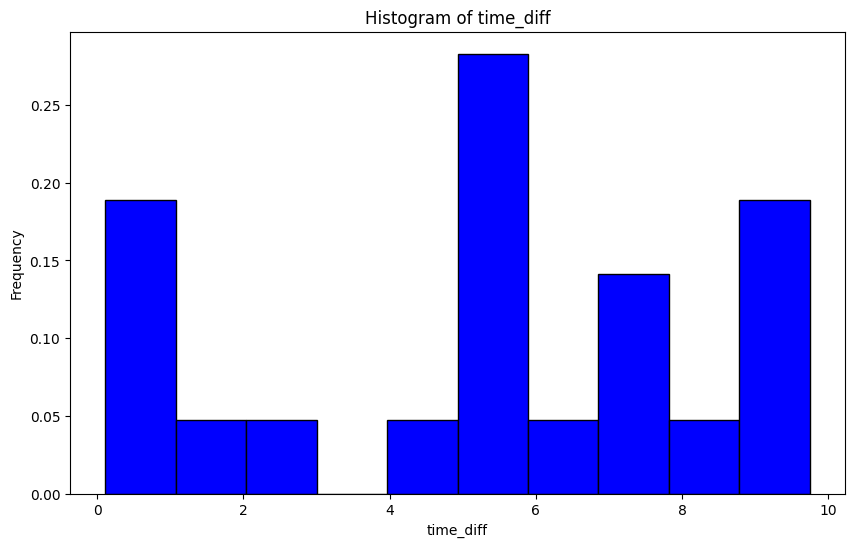

In [16]:
plot_data_histogram(data_df, "time_diff")

In [17]:
latency = median_latency(data_df)

In [18]:
latency

5.5314795